In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial.distance import pdist, squareform

# Load the selected feature datasets
selected_cna = pd.read_csv("cna_selected.csv")  # CNA
selected_methylation = pd.read_csv("methylation_selected.csv")  # Methylation
selected_mrna = pd.read_csv("mrna_selected.csv")  # mRNA

# Function to create patient similarity network
def construct_similarity_network(data, method="pearson", top_n=3, output_file="network.edgelist"):
    """
    Constructs a patient similarity network based on top N similar patients.
    
    Parameters:
    - data: DataFrame with Sample_ID as first column and features as the rest.
    - method: Similarity method ('pearson' for Pearson correlation, 'euclidean' for Euclidean distance).
    - top_n: Number of top similar neighbors to retain for each patient.
    - output_file: Filename to save the network edge list.
    
    Returns:
    - Graph object (NetworkX)
    """

    # Extract Sample_IDs and features
    sample_ids = data["Sample_ID"].values
    feature_matrix = data.drop(columns=["Sample_ID"]).values

    # Compute similarity matrix
    if method == "pearson":
        similarity_matrix = np.corrcoef(feature_matrix)  # Pearson correlation
    elif method == "euclidean":
        dist_matrix = squareform(pdist(feature_matrix, metric="euclidean"))  # Compute distance
        similarity_matrix = 1 / (1 + dist_matrix)  # Convert distance to similarity

    # Convert similarity matrix to DataFrame
    similarity_df = pd.DataFrame(similarity_matrix, index=sample_ids, columns=sample_ids)

    # Create an empty graph
    G = nx.Graph()

    # Add nodes (patients)
    G.add_nodes_from(sample_ids)

    # Add top N edges per patient
    for patient in sample_ids:
        neighbors = similarity_df.loc[patient].drop(patient).nlargest(top_n)  # Find top N similar patients
        for neighbor, similarity in neighbors.items():
            G.add_edge(patient, neighbor, weight=similarity)

    # Save network as an edge list
    nx.write_edgelist(G, output_file, data=["weight"])
    
    print(f"Network saved as {output_file} with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

# Construct networks for each omics dataset
cna_network = construct_similarity_network(selected_cna, method="pearson", output_file="cna_network.edgelist")
methylation_network = construct_similarity_network(selected_methylation, method="pearson", output_file="methylation_network.edgelist")
mrna_network = construct_similarity_network(selected_mrna, method="pearson", output_file="mrna_network.edgelist")

print("Patient similarity networks constructed successfully!")


Network saved as cna_network.edgelist with 199 nodes and 404 edges.
Network saved as methylation_network.edgelist with 199 nodes and 426 edges.
Network saved as mrna_network.edgelist with 199 nodes and 456 edges.
Patient similarity networks constructed successfully!


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from gower import gower_matrix  # Install with: pip install gower

# -------------------- 1. Load Clinical Data -------------------- #
clinical_data = pd.read_csv("data_clinical_patient_preprocessed.csv")

# Ensure the first column is named 'Sample_ID' and convert it to a plain string
if "Sample_ID" not in clinical_data.columns:
    clinical_data.rename(columns={clinical_data.columns[0]: "Sample_ID"}, inplace=True)
clinical_data["Sample_ID"] = clinical_data["Sample_ID"].astype(str)

# Drop the Survival_Label column (if it exists) so it is not used for similarity calculation
if "Survival_Label" in clinical_data.columns:
    clinical_data = clinical_data.drop(columns=["Survival_Label"])

def construct_clinical_similarity_network(data, top_n=3, output_file="clinical_network.edgelist"):
    """
    Constructs a patient similarity network using Gower distance for mixed clinical data.
    It excludes identifier/outcome columns (Sample_ID and Survival_Label) from the similarity calculation.
    """
    # Exclude Sample_ID from the feature matrix.
    features_df = data.drop(columns=["Sample_ID"])
    
    # Convert the Sample_ID column to a list of strings for graph nodes.
    sample_ids = data["Sample_ID"].values.tolist()
    
    # Compute Gower similarity matrix from the clinical features.
    feature_matrix = features_df.values
    gower_distance_matrix = gower_matrix(feature_matrix)
    gower_sim_matrix = 1 - gower_distance_matrix  # Convert distance to similarity
    
    # Create a DataFrame for the similarity matrix with sample_ids as both index and columns.
    similarity_df = pd.DataFrame(gower_sim_matrix, index=sample_ids, columns=sample_ids)
    
    # Remove self-similarity by setting the diagonal to 0.
    np.fill_diagonal(gower_sim_matrix, 0)
    
    # Create an empty graph and add nodes from sample_ids.
    G = nx.Graph()
    G.add_nodes_from(sample_ids)
    
    # For each patient, add edges to the top_n most similar patients.
    for patient in sample_ids:
        # Get the top_n neighbors (highest similarity values) for the current patient.
        neighbors = similarity_df.loc[patient].nlargest(top_n)
        for neighbor, similarity in neighbors.items():
            G.add_edge(patient, neighbor, weight=similarity)
    
    # Save the network edge list to a file.
    nx.write_edgelist(G, output_file, data=["weight"])
    print(f"Clinical similarity network saved as {output_file}.")
    return G

# Construct and save the clinical network.
clinical_network = construct_clinical_similarity_network(clinical_data, top_n=3, output_file="clinical_network.edgelist")


Clinical similarity network saved as clinical_network.edgelist.


In [3]:
import networkx as nx

# List the edgelist files from the individual networks
edgelist_files = [
    "cna_network.edgelist", 
    "methylation_network.edgelist", 
    "mrna_network.edgelist", 
    "clinical_network.edgelist"
]

# Create an empty graph for the final merged network
final_network = nx.Graph()

# Iterate through each edgelist file and merge the edges
for file in edgelist_files:
    # Read the edgelist file; assume weight attribute is stored as float
    G = nx.read_edgelist(file, data=(("weight", float),))
    
    # Add edges from this network to the final network
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1.0)
        # If the edge already exists, sum the weights
        if final_network.has_edge(u, v):
            final_network[u][v]["weight"] += w
        else:
            final_network.add_edge(u, v, weight=w)

# Save the final merged network as an edgelist
nx.write_edgelist(final_network, "final_patient_network.edgelist", data=["weight"])
print(f"Final patient network saved as 'final_patient_network.edgelist' with {final_network.number_of_nodes()} nodes and {final_network.number_of_edges()} edges.")


Final patient network saved as 'final_patient_network.edgelist' with 199 nodes and 1592 edges.


In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 1. Load Patient Similarity Network
print("🔹 Loading patient similarity network...")
G = nx.read_edgelist("final_patient_network.edgelist", nodetype=str, data=[("weight", float)])

# Ensure all edges have weights
for u, v in G.edges():
    if "weight" not in G[u][v]:
        G[u][v]["weight"] = 1.0

# 2. Load Omics & Clinical Features
print("🔹 Loading patient features...")
clinical_data = pd.read_csv("data_clinical_patient_preprocessed.csv")
mrna_data = pd.read_csv("mrna_selected.csv")
methylation_data = pd.read_csv("methylation_selected.csv")
cna_data = pd.read_csv("cna_selected.csv")

# Remove 'Survival_Label' from feature files (avoid merge conflicts)
for df in [clinical_data, mrna_data, methylation_data, cna_data]:
    if "Survival_Label" in df.columns:
        df.drop(columns=["Survival_Label"], inplace=True)

# Merge all features using "Sample_ID"
features = clinical_data.merge(mrna_data, on="Sample_ID", how="inner") \
                        .merge(methylation_data, on="Sample_ID", how="inner") \
                        .merge(cna_data, on="Sample_ID", how="inner")

# Convert to NumPy array
sample_ids = features["Sample_ID"].values
node_features = features.drop(columns=["Sample_ID"]).to_numpy()

# 3. Convert NetworkX Graph to PyTorch Geometric format
print("🔹 Converting network to PyTorch Geometric format...")
data = from_networkx(G, group_edge_attrs=["weight"])

# 4. Attach Node Features
data.x = torch.tensor(node_features, dtype=torch.float)

# 5. Load Labels (Survival_Status)
print("🔹 Loading survival labels...")
survival_labels = pd.read_csv("survival_labels.csv")  # Ensure it has "Sample_ID" & "Survival_Label"
sample_id_to_label = dict(zip(survival_labels["Sample_ID"], survival_labels["Survival_Label"]))

# Assign labels to nodes in correct order
data.y = torch.tensor([sample_id_to_label.get(sid, 0) for sid in sample_ids], dtype=torch.long)

# 6. Move Everything to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.x = data.x.to(device)
data.y = data.y.to(device)
data.edge_index = data.edge_index.to(device)
data.edge_attr = data.edge_attr.to(device)

print("Graph successfully loaded with node features and labels!")

# 7. Define GAT Model
class GATModel(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads=1, dropout=0.6):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_features, hidden_features, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_features * num_heads, out_features, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x, x  # Return logits & embeddings

# 8. Initialize GAT Model
in_features = data.x.shape[1]
model = GATModel(in_features=in_features, hidden_features=16, out_features=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# 9. Train GAT Model
def train():
    model.train()
    optimizer.zero_grad()
    out, embeddings = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item(), embeddings

best_embeddings = None
for epoch in range(100):
    loss, embeddings = train()
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
    best_embeddings = embeddings

# 10. Save GAT Embeddings with Sample_ID
print("Saving GAT embeddings...")
best_embeddings = best_embeddings.cpu().detach().numpy()
embedding_df = pd.DataFrame(best_embeddings)
embedding_df.insert(0, "Sample_ID", sample_ids)  # Insert Sample_ID for correct alignment
embedding_df.to_csv("custom_gat_embeddings.csv", index=False)
print("Saved embeddings to 'custom_gat_embeddings.csv'.")

# 11. Train Classifier on GAT Embeddings
print("🔹 Training survival classifier...")

# Load embeddings
embeddings = pd.read_csv("custom_gat_embeddings.csv")
embeddings["Sample_ID"] = embeddings["Sample_ID"].astype(str)
survival_labels["Sample_ID"] = survival_labels["Sample_ID"].astype(str)

# Merge labels with embeddings
merged_data = pd.merge(survival_labels, embeddings, on="Sample_ID", how="inner")

# Extract Features (Embeddings) and Labels (Survival Status)
X = merged_data.drop(columns=["Sample_ID", "Survival_Label"]).values
y = merged_data["Survival_Label"].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Choose Classifier (Change this to try different models)
classifier_type = "MLP"  # Options: "MLP", "XGBoost", "RF", "SVM"

if classifier_type == "MLP":
    clf = MLPClassifier(hidden_layer_sizes=(128,), activation="relu", solver="adam", max_iter=500)
elif classifier_type == "XGBoost":
    clf = XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss", n_estimators=200)
elif classifier_type == "RF":
    clf = RandomForestClassifier(n_estimators=200, max_depth=10)
elif classifier_type == "SVM":
    clf = SVC(kernel="rbf", probability=True)

# Train the Classifier
clf.fit(X_train, y_train)

# Make Predictions
y_pred = clf.predict(X_test)

# Evaluate Model Performance
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print(f"\nClassifier: {classifier_type}")
print(f"Accuracy: {acc:.3f}")
print(f"Macro-F1: {f1_macro:.3f}")
print(f"Weighted-F1: {f1_weighted:.3f}")

# Save Model Results
results = pd.DataFrame({
    "Classifier": [classifier_type],
    "Accuracy": [acc],
    "Macro-F1": [f1_macro],
    "Weighted-F1": [f1_weighted]
})
results.to_csv(f"{classifier_type}_results.csv", index=False)
print(f"Saved {classifier_type} model results.")


🔹 Loading patient similarity network...
🔹 Loading patient features...
🔹 Converting network to PyTorch Geometric format...
🔹 Loading survival labels...
Graph successfully loaded with node features and labels!
Epoch 1, Loss: 0.7827
Epoch 2, Loss: 0.7501
Epoch 3, Loss: 0.6810
Epoch 4, Loss: 0.7808
Epoch 5, Loss: 0.7829
Epoch 6, Loss: 1.1369
Epoch 7, Loss: 0.7610
Epoch 8, Loss: 0.7231
Epoch 9, Loss: 0.6749
Epoch 10, Loss: 0.6989
Epoch 11, Loss: 0.7454
Epoch 12, Loss: 0.7073
Epoch 13, Loss: 0.7048
Epoch 14, Loss: 0.6961
Epoch 15, Loss: 0.7178
Epoch 16, Loss: 0.6999
Epoch 17, Loss: 0.7430
Epoch 18, Loss: 0.6803
Epoch 19, Loss: 0.6850
Epoch 20, Loss: 0.7003
Epoch 21, Loss: 0.6970
Epoch 22, Loss: 0.6976
Epoch 23, Loss: 0.6417
Epoch 24, Loss: 0.6777
Epoch 25, Loss: 0.6436
Epoch 26, Loss: 0.6899
Epoch 27, Loss: 0.6577
Epoch 28, Loss: 0.6752
Epoch 29, Loss: 0.6645
Epoch 30, Loss: 0.6266
Epoch 31, Loss: 0.6542
Epoch 32, Loss: 0.6696
Epoch 33, Loss: 0.6660
Epoch 34, Loss: 0.6391
Epoch 35, Loss: 0.6

🔹 Loading GAT embeddings and survival labels...
🔹 Training individual classifiers...


C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 Model Performance:
Accuracy: 0.600
Macro-F1: 0.599
Weighted-F1: 0.601
Sensitivity (Recall for Positive Class): 0.591
Specificity (Recall for Negative Class): 0.611
Saved ensemble model results to 'ensemble_results.csv'.


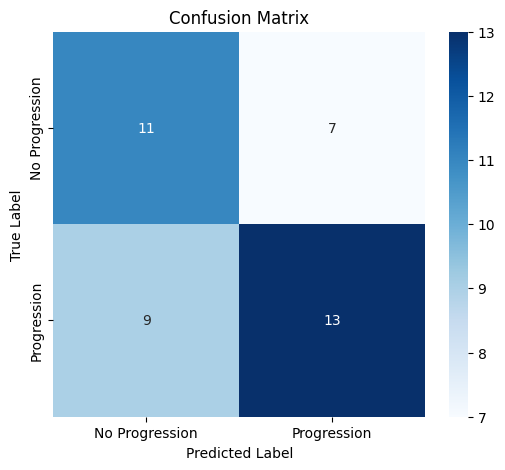

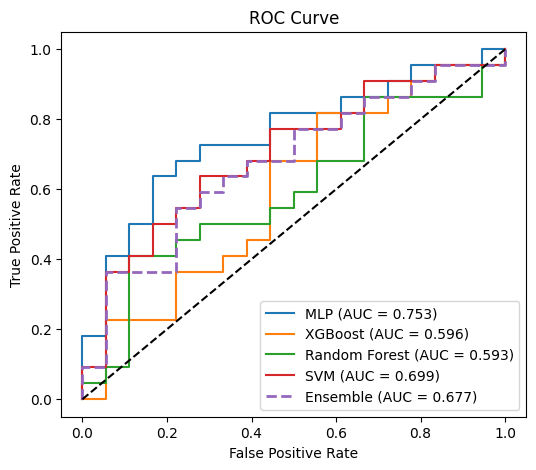

Data visualizations generated!


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from scipy.stats import mode

# 1. Load GAT Embeddings and Survival Labels
print("🔹 Loading GAT embeddings and survival labels...")
embeddings = pd.read_csv("custom_gat_embeddings.csv")
survival_labels = pd.read_csv("survival_labels.csv")

# Ensure 'Sample_ID' is of type string
embeddings["Sample_ID"] = embeddings["Sample_ID"].astype(str)
survival_labels["Sample_ID"] = survival_labels["Sample_ID"].astype(str)

# 2. Merge Labels with Embeddings
merged_data = pd.merge(survival_labels, embeddings, on="Sample_ID", how="inner")

# Extract Features (Embeddings) and Labels (Survival Status)
X = merged_data.drop(columns=["Sample_ID", "Survival_Label"]).values
y = merged_data["Survival_Label"].values

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Define Individual Classifiers
print("🔹 Training individual classifiers...")
mlp = MLPClassifier(hidden_layer_sizes=(128,), activation="relu", solver="adam", max_iter=500)
xgb = XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss", n_estimators=200)
rf = RandomForestClassifier(n_estimators=200, max_depth=10)
svm = SVC(kernel="rbf", probability=True)

# 5. Train Each Classifier
mlp.fit(X_train, y_train)
xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

# 6. Make Predictions from All Models
y_pred_mlp = mlp.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_svm = svm.predict(X_test)

# Collect predictions from all classifiers
all_preds = np.array([y_pred_mlp, y_pred_xgb, y_pred_rf, y_pred_svm])

# 7. Ensemble Model (Majority Voting)
from scipy.stats import mode
y_pred_ensemble = mode(all_preds, axis=0).mode.flatten()


# 8. Compute Metrics
accuracy = accuracy_score(y_test, y_pred_ensemble)
f1_macro = f1_score(y_test, y_pred_ensemble, average="macro")
f1_weighted = f1_score(y_test, y_pred_ensemble, average="weighted")
sensitivity = recall_score(y_test, y_pred_ensemble, pos_label=1)  # True Positive Rate
specificity = recall_score(y_test, y_pred_ensemble, pos_label=0)  # True Negative Rate

print("\n🔹 Model Performance:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Macro-F1: {f1_macro:.3f}")
print(f"Weighted-F1: {f1_weighted:.3f}")
print(f"Sensitivity (Recall for Positive Class): {sensitivity:.3f}")
print(f"Specificity (Recall for Negative Class): {specificity:.3f}")


# 9. Save Model Results
results = pd.DataFrame({
    "Classifier": ["Ensemble"],
    "Accuracy": [accuracy],
    "Macro-F1": [f1_macro],
    "Weighted-F1": [f1_weighted],
    "Sensitivity": [sensitivity],
    "Specificity": [specificity]
})
results.to_csv("ensemble_results.csv", index=False)
print("Saved ensemble model results to 'ensemble_results.csv'.")

# 10. Generate Data Visualizations

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Progression", "Progression"],
            yticklabels=["No Progression", "Progression"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 🔹 ROC Curve
plt.figure(figsize=(6, 5))
for clf, name in zip([mlp, xgb, rf, svm], ["MLP", "XGBoost", "Random Forest", "SVM"]):
    y_prob = clf.predict_proba(X_test)[:, 1]  # Get positive class probabilities
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# ROC Curve for Ensemble
y_prob_ensemble = (mlp.predict_proba(X_test)[:, 1] + xgb.predict_proba(X_test)[:, 1] +
                   rf.predict_proba(X_test)[:, 1] + svm.predict_proba(X_test)[:, 1]) / 4
fpr, tpr, _ = roc_curve(y_test, y_prob_ensemble)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, linestyle="--", label=f"Ensemble (AUC = {roc_auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

print("Data visualizations generated!")


Loading GAT embeddings and survival labels...
Checking class distribution...
Class Distribution: {1: 89, 0: 70}


C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Model Performance:
Accuracy: 0.550
Macro-F1: 0.545
Weighted-F1: 0.550
Sensitivity (TPR): 0.591
Specificity (TNR): 0.500


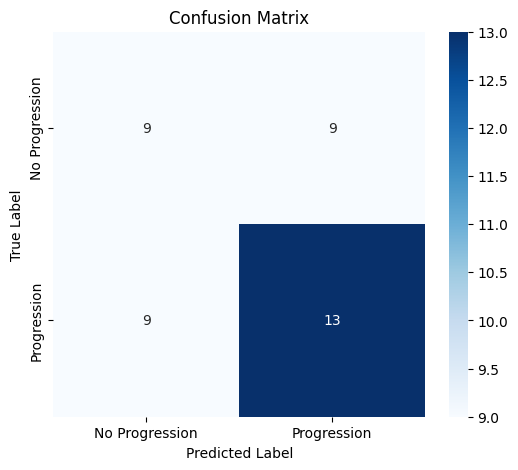

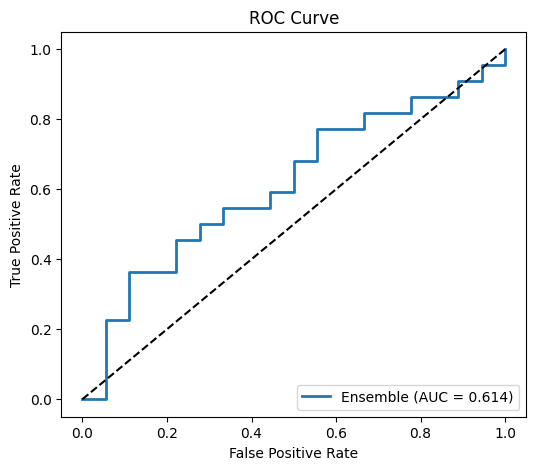


🔹 Feature Summary Table:
+---+-------------+-------------------+------------------+----------------+
|   | Omics Type  | Original Features | Reduced Features | GAT Embeddings |
+---+-------------+-------------------+------------------+----------------+
| 0 |    mRNA     |       20000       |       1000       |      128       |
| 1 | Methylation |      450000       |       1000       |      128       |
| 2 |     CNA     |       25000       |       1000       |      128       |
+---+-------------+-------------------+------------------+----------------+

🔹 Sample Distribution Table:
+---+----------------+-------+
|   |     Class      | Count |
+---+----------------+-------+
| 0 | No Progression |  88   |
| 1 |  Progression   |  111  |
+---+----------------+-------+
Final results saved and visualizations generated.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from scipy.stats import mode
from scipy import stats
import itertools
from tabulate import tabulate  #  Added correct table formatting

#  1. Load GAT Embeddings and Survival Labels
print("Loading GAT embeddings and survival labels...")
embeddings = pd.read_csv("custom_gat_embeddings.csv")
survival_labels = pd.read_csv("survival_labels.csv")

# Ensure 'Sample_ID' is of type string
embeddings["Sample_ID"] = embeddings["Sample_ID"].astype(str)
survival_labels["Sample_ID"] = survival_labels["Sample_ID"].astype(str)

#  2. Merge Labels with Embeddings
merged_data = pd.merge(survival_labels, embeddings, on="Sample_ID", how="inner")

# Extract Features (Embeddings) and Labels (Survival Status)
X = merged_data.drop(columns=["Sample_ID", "Survival_Label"]).values
y = merged_data["Survival_Label"].values

#  3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  4. Handle Class Imbalance (SMOTE if needed)
print("Checking class distribution...")
class_counts = pd.Series(y_train).value_counts()
print(f"Class Distribution: {class_counts.to_dict()}")

if min(class_counts) / max(class_counts) < 0.5:
    print("Imbalance detected, applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("SMOTE applied, class distribution is now balanced.")

#  5. Define Optimized Classifiers
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), activation="relu", solver="adam", max_iter=1000)
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric="logloss")
rf = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=2)
svm = SVC(kernel="rbf", C=1, probability=True)

#  6. Create Soft Voting Ensemble
ensemble = VotingClassifier(estimators=[
    ('MLP', mlp),
    ('XGB', xgb),
    ('RF', rf),
    ('SVM', svm)
], voting="soft")

#  7. Train the Ensemble Model
ensemble.fit(X_train, y_train)

#  8. Make Predictions
y_pred = ensemble.predict(X_test)
y_prob = ensemble.predict_proba(X_test)[:, 1]

#  9. Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
sensitivity = recall_score(y_test, y_pred, pos_label=1)
specificity = recall_score(y_test, y_pred, pos_label=0)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Macro-F1: {f1_macro:.3f}")
print(f"Weighted-F1: {f1_weighted:.3f}")
print(f"Sensitivity (TPR): {sensitivity:.3f}")
print(f"Specificity (TNR): {specificity:.3f}")

#  10. Save Model Results
results = pd.DataFrame({
    "Classifier": ["Ensemble (Soft Voting)"],
    "Accuracy": [accuracy],
    "Macro-F1": [f1_macro],
    "Weighted-F1": [f1_weighted],
    "Sensitivity": [sensitivity],
    "Specificity": [specificity]
})
results.to_csv("ensemble_results.csv", index=False)

#  11. Generate Data Visualizations

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Progression", "Progression"],
            yticklabels=["No Progression", "Progression"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 🔹 ROC Curve
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Ensemble (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#  12. Feature Summary Table
feature_summary = pd.DataFrame({
    "Omics Type": ["mRNA", "Methylation", "CNA"],
    "Original Features": [20000, 450000, 25000],  # Adjust based on dataset
    "Reduced Features": [1000, 1000, 1000],
    "GAT Embeddings": [128, 128, 128]
})

print("\n🔹 Feature Summary Table:")
print(tabulate(feature_summary, headers='keys', tablefmt='pretty'))

#  13. Sample Distribution Table
sample_distribution = pd.DataFrame({
    "Class": ["No Progression", "Progression"],
    "Count": [sum(y == 0), sum(y == 1)]
})

print("\n🔹 Sample Distribution Table:")
print(tabulate(sample_distribution, headers='keys', tablefmt='pretty'))

print("Final results saved and visualizations generated.")


🔹 Loading patient similarity network...
🔹 Loading patient features...
🔹 Converting network to PyTorch Geometric format...
🔹 Loading survival labels...
Graph successfully loaded with node features and labels!
Epoch 001 | Loss: 0.8385 | Training Accuracy: 0.5276
Epoch 002 | Loss: 0.7413 | Training Accuracy: 0.5477
Epoch 003 | Loss: 0.7098 | Training Accuracy: 0.5226
Epoch 004 | Loss: 0.6974 | Training Accuracy: 0.5879
Epoch 005 | Loss: 0.7174 | Training Accuracy: 0.4874
Epoch 006 | Loss: 0.6849 | Training Accuracy: 0.5578
Epoch 007 | Loss: 0.6789 | Training Accuracy: 0.5477
Epoch 008 | Loss: 0.6857 | Training Accuracy: 0.6131
Epoch 009 | Loss: 0.6878 | Training Accuracy: 0.5729
Epoch 010 | Loss: 0.6928 | Training Accuracy: 0.5226
Epoch 011 | Loss: 0.6582 | Training Accuracy: 0.5930
Epoch 012 | Loss: 0.6528 | Training Accuracy: 0.6382
Epoch 013 | Loss: 0.6783 | Training Accuracy: 0.5729
Epoch 014 | Loss: 0.6647 | Training Accuracy: 0.6080
Epoch 015 | Loss: 0.6794 | Training Accuracy: 0.59

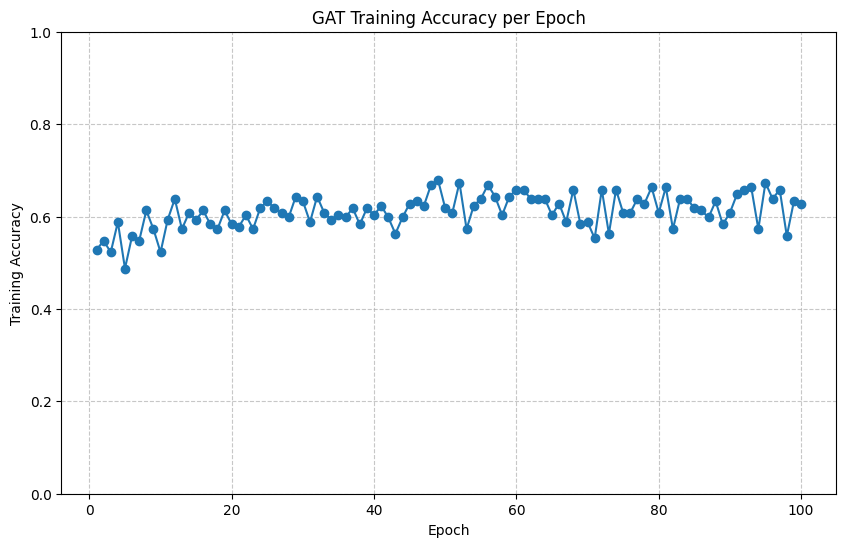

Saving GAT embeddings...
Saved embeddings to 'custom_gat_embeddings.csv'.
🔹 Training survival classifier...

Classifier: MLP
Accuracy: 0.600
Macro-F1: 0.599
Weighted-F1: 0.597
Saved MLP model results.


In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# 1. Load Patient Similarity Network
print("🔹 Loading patient similarity network...")
G = nx.read_edgelist("final_patient_network.edgelist", nodetype=str, data=[("weight", float)])

# Ensure all edges have weights
for u, v in G.edges():
    if "weight" not in G[u][v]:
        G[u][v]["weight"] = 1.0

# 2. Load Omics & Clinical Features
print("🔹 Loading patient features...")
clinical_data = pd.read_csv("data_clinical_patient_preprocessed.csv")
mrna_data = pd.read_csv("mrna_selected.csv")
methylation_data = pd.read_csv("methylation_selected.csv")
cna_data = pd.read_csv("cna_selected.csv")

# Remove 'Survival_Label' from feature files (avoid merge conflicts)
for df in [clinical_data, mrna_data, methylation_data, cna_data]:
    if "Survival_Label" in df.columns:
        df.drop(columns=["Survival_Label"], inplace=True)

# Merge all features using "Sample_ID"
features = clinical_data.merge(mrna_data, on="Sample_ID", how="inner") \
                        .merge(methylation_data, on="Sample_ID", how="inner") \
                        .merge(cna_data, on="Sample_ID", how="inner")

# Convert to NumPy array
sample_ids = features["Sample_ID"].values
node_features = features.drop(columns=["Sample_ID"]).to_numpy()

# 3. Convert NetworkX Graph to PyTorch Geometric format
print("🔹 Converting network to PyTorch Geometric format...")
data = from_networkx(G, group_edge_attrs=["weight"])

# 4. Attach Node Features
data.x = torch.tensor(node_features, dtype=torch.float)

# 5. Load Labels (Survival_Status)
print("🔹 Loading survival labels...")
survival_labels = pd.read_csv("survival_labels.csv")  # Ensure it has "Sample_ID" & "Survival_Label"
sample_id_to_label = dict(zip(survival_labels["Sample_ID"], survival_labels["Survival_Label"]))

# Assign labels to nodes in correct order
data.y = torch.tensor([sample_id_to_label.get(sid, 0) for sid in sample_ids], dtype=torch.long)

# 6. Move Everything to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.x = data.x.to(device)
data.y = data.y.to(device)
data.edge_index = data.edge_index.to(device)
data.edge_attr = data.edge_attr.to(device)

print("Graph successfully loaded with node features and labels!")

# 7. Define GAT Model
class GATModel(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads=1, dropout=0.6):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_features, hidden_features, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_features * num_heads, out_features, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x, x  # Return logits & embeddings

# 8. Initialize GAT Model
in_features = data.x.shape[1]
model = GATModel(in_features=in_features, hidden_features=16, out_features=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# 9. Train GAT Model with Accuracy Tracking
train_accuracies = []

def train():
    model.train()
    optimizer.zero_grad()
    out, embeddings = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item(), out, embeddings

best_embeddings = None
num_epochs = 100
for epoch in range(num_epochs):
    loss, out, embeddings = train()
    # Calculate training accuracy on the full graph
    _, pred = torch.max(out, 1)
    acc = (pred == data.y).sum().item() / len(data.y)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1:03d} | Loss: {loss:.4f} | Training Accuracy: {acc:.4f}")
    best_embeddings = embeddings  # Save the embeddings from the last epoch

# 10. Plot Training Accuracy Over Epochs (Line Graph)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("GAT Training Accuracy per Epoch")
plt.ylim(0, 1)  # Y-axis scaled from 0 to 1
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# 11. Save GAT Embeddings with Sample_ID
print("Saving GAT embeddings...")
best_embeddings = best_embeddings.cpu().detach().numpy()
embedding_df = pd.DataFrame(best_embeddings)
embedding_df.insert(0, "Sample_ID", sample_ids)  # Insert Sample_ID for correct alignment
embedding_df.to_csv("custom_gat_embeddings.csv", index=False)
print("Saved embeddings to 'custom_gat_embeddings.csv'.")

# 12. Train Classifier on GAT Embeddings
print("🔹 Training survival classifier...")

# Load embeddings
embeddings = pd.read_csv("custom_gat_embeddings.csv")
embeddings["Sample_ID"] = embeddings["Sample_ID"].astype(str)
survival_labels["Sample_ID"] = survival_labels["Sample_ID"].astype(str)

# Merge labels with embeddings
merged_data = pd.merge(survival_labels, embeddings, on="Sample_ID", how="inner")

# Extract Features (Embeddings) and Labels (Survival Status)
X = merged_data.drop(columns=["Sample_ID", "Survival_Label"]).values
y = merged_data["Survival_Label"].values

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Choose Classifier (Change this to try different models)
classifier_type = "MLP"  # Options: "MLP", "XGBoost", "RF", "SVM"

if classifier_type == "MLP":
    from sklearn.neural_network import MLPClassifier
    clf = MLPClassifier(hidden_layer_sizes=(128,), activation="relu", solver="adam", max_iter=500)
elif classifier_type == "XGBoost":
    from xgboost import XGBClassifier
    clf = XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss", n_estimators=200)
elif classifier_type == "RF":
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=200, max_depth=10)
elif classifier_type == "SVM":
    from sklearn.svm import SVC
    clf = SVC(kernel="rbf", probability=True)

# Train the Classifier
clf.fit(X_train, y_train)

# Make Predictions and Evaluate
from sklearn.metrics import accuracy_score, f1_score
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print(f"\nClassifier: {classifier_type}")
print(f"Accuracy: {acc:.3f}")
print(f"Macro-F1: {f1_macro:.3f}")
print(f"Weighted-F1: {f1_weighted:.3f}")

# Save Classifier Results
results = pd.DataFrame({
    "Classifier": [classifier_type],
    "Accuracy": [acc],
    "Macro-F1": [f1_macro],
    "Weighted-F1": [f1_weighted]
})
results.to_csv(f"{classifier_type}_results.csv", index=False)
print(f"Saved {classifier_type} model results.")


Loading GAT embeddings and survival labels...

Training MLP with 5-Fold Cross-Validation:
  Fold 1 - Accuracy: 0.650
  Fold 2 - Accuracy: 0.600
  Fold 3 - Accuracy: 0.650
  Fold 4 - Accuracy: 0.675
  Fold 5 - Accuracy: 0.615

Training XGBoost with 5-Fold Cross-Validation:


C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 1 - Accuracy: 0.550
  Fold 2 - Accuracy: 0.600


C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 3 - Accuracy: 0.550


C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 4 - Accuracy: 0.575


C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold 5 - Accuracy: 0.667

Training RandomForest with 5-Fold Cross-Validation:
  Fold 1 - Accuracy: 0.500
  Fold 2 - Accuracy: 0.500
  Fold 3 - Accuracy: 0.550
  Fold 4 - Accuracy: 0.650
  Fold 5 - Accuracy: 0.615

Training SVM with 5-Fold Cross-Validation:
  Fold 1 - Accuracy: 0.625
  Fold 2 - Accuracy: 0.575
  Fold 3 - Accuracy: 0.675
  Fold 4 - Accuracy: 0.675
  Fold 5 - Accuracy: 0.615


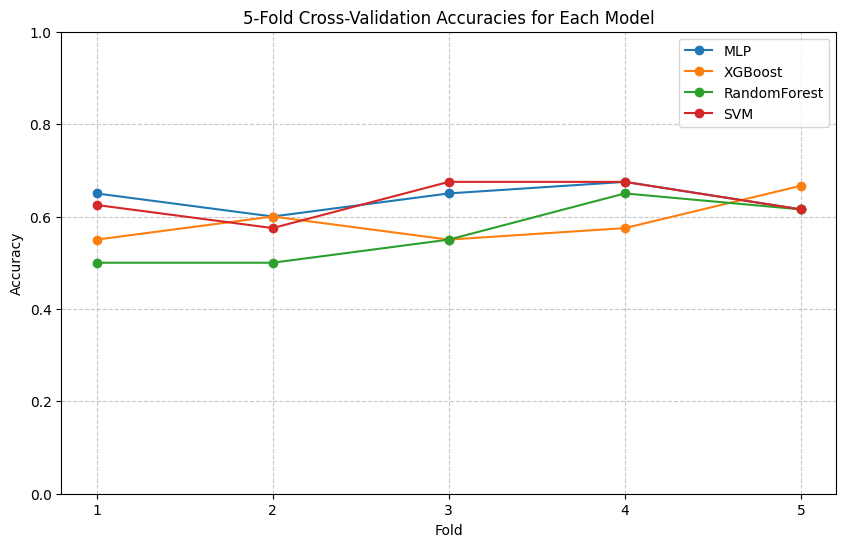

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# --- Load Embeddings and Survival Labels ---
print("Loading GAT embeddings and survival labels...")
embeddings = pd.read_csv("custom_gat_embeddings.csv")
survival_labels = pd.read_csv("survival_labels.csv")

# Ensure "Sample_ID" is string
embeddings["Sample_ID"] = embeddings["Sample_ID"].astype(str)
survival_labels["Sample_ID"] = survival_labels["Sample_ID"].astype(str)

# Merge labels with embeddings
merged_data = pd.merge(survival_labels, embeddings, on="Sample_ID", how="inner")
X = merged_data.drop(columns=["Sample_ID", "Survival_Label"]).values
y = merged_data["Survival_Label"].values

# --- Define Classifiers ---
models = {
    "MLP": MLPClassifier(hidden_layer_sizes=(128,), activation="relu", solver="adam", max_iter=500),
    "XGBoost": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss", n_estimators=200),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10),
    "SVM": SVC(kernel="rbf", probability=True)
}

# --- 5-Fold Cross Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = {}

for name, clf in models.items():
    fold_acc = []
    print(f"\nTraining {name} with 5-Fold Cross-Validation:")
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        fold_acc.append(acc)
        print(f"  Fold {fold} - Accuracy: {acc:.3f}")
    fold_accuracies[name] = fold_acc

# --- Plot Accuracies for Each Fold as a Line Graph ---
plt.figure(figsize=(10, 6))
fold_numbers = np.arange(1, 6)  # Folds 1 through 5

for name, accs in fold_accuracies.items():
    plt.plot(fold_numbers, accs, marker='o', linestyle='-', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross-Validation Accuracies for Each Model")
plt.ylim(0, 1)  # Set Y-axis from 0 to 1
plt.xticks(fold_numbers)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc, confusion_matrix
)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from tabulate import tabulate

# 1. Load GAT Embeddings and Survival Labels
print("Loading GAT embeddings and survival labels...")
embeddings = pd.read_csv("custom_gat_embeddings.csv")  # Output from your GAT model
survival_labels = pd.read_csv("survival_labels.csv")

# Ensure "Sample_ID" is string
embeddings["Sample_ID"] = embeddings["Sample_ID"].astype(str)
survival_labels["Sample_ID"] = survival_labels["Sample_ID"].astype(str)

# Merge labels with embeddings
merged_data = pd.merge(survival_labels, embeddings, on="Sample_ID", how="inner")

# Extract Features (Embeddings) and Labels (Survival Status)
X = merged_data.drop(columns=["Sample_ID", "Survival_Label"]).values
y = merged_data["Survival_Label"].values

# 2. Define Classifiers
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), activation="relu", solver="adam", max_iter=5000, random_state=42)
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric="logloss", random_state=42)
rf = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42)
svm = SVC(kernel="rbf", C=1, probability=True, random_state=42)

# Ensemble (Soft Voting)
ensemble = VotingClassifier(estimators=[
    ('MLP', mlp),
    ('XGB', xgb),
    ('RF', rf),
    ('SVM', svm)
], voting="soft")

models = {
    "MLP": mlp,
    "XGB": xgb,
    "RandomForest": rf,
    "SVM": svm,
    "Ensemble": ensemble
}

# 3. Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare a structure to store per-fold results
results_summary = {model_name: [] for model_name in models.keys()}

# 4. Perform 5-Fold Cross-Validation for Each Model
for model_name, model in models.items():
    print(f"\n{'=' * 20}\nTraining {model_name} with 5-Fold Cross-Validation")
    fold = 1
    fold_results = []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # (Optional) Handle imbalance with SMOTE
        # If your data is imbalanced, uncomment the lines below:
        if np.min(np.bincount(y_train)) / np.max(np.bincount(y_train)) < 0.5:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Probability for positive class

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average="macro")
        f1_weighted = f1_score(y_test, y_pred, average="weighted")
        sensitivity = recall_score(y_test, y_pred, pos_label=1)  # TPR
        specificity = recall_score(y_test, y_pred, pos_label=0)  # TNR
        precision = precision_score(y_test, y_pred, average="macro")
        recall_avg = recall_score(y_test, y_pred, average="macro")
        auc_score = roc_auc_score(y_test, y_prob)

        fold_result = {
            "Fold": fold,
            "Accuracy": accuracy,
            "Macro-F1": f1_macro,
            "Weighted-F1": f1_weighted,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "Precision": precision,
            "Recall": recall_avg,
            "AUC": auc_score
        }

        fold_results.append(fold_result)
        print(f"Fold {fold} - Accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}, "
              f"Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}, "
              f"Precision: {precision:.3f}, Recall: {recall_avg:.3f}")
        fold += 1

    # Store each fold's results
    results_summary[model_name] = fold_results

# 5. Aggregate Results and Print Summary Table
final_summary = []
for model_name, folds in results_summary.items():
    metrics_df = pd.DataFrame(folds)
    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    final_summary.append({
        "Model": model_name,
        "Accuracy": f"{avg_metrics['Accuracy']:.3f} ± {std_metrics['Accuracy']:.3f}",
        "Macro-F1": f"{avg_metrics['Macro-F1']:.3f} ± {std_metrics['Macro-F1']:.3f}",
        "Weighted-F1": f"{avg_metrics['Weighted-F1']:.3f} ± {std_metrics['Weighted-F1']:.3f}",
        "Sensitivity": f"{avg_metrics['Sensitivity']:.3f} ± {std_metrics['Sensitivity']:.3f}",
        "Specificity": f"{avg_metrics['Specificity']:.3f} ± {std_metrics['Specificity']:.3f}",
        "Precision": f"{avg_metrics['Precision']:.3f} ± {std_metrics['Precision']:.3f}",
        "Recall": f"{avg_metrics['Recall']:.3f} ± {std_metrics['Recall']:.3f}",
        "AUC": f"{avg_metrics['AUC']:.3f} ± {std_metrics['AUC']:.3f}"
    })

summary_df = pd.DataFrame(final_summary)

# Save final summary to CSV
summary_df.to_csv("cross_validation_results.csv", index=False)

# Print final summary using tabulate
print("\nFinal Cross-Validation Summary:")
print(tabulate(summary_df, headers="keys", tablefmt="pretty"))


Loading GAT embeddings and survival labels...

Training MLP with 5-Fold Cross-Validation
Fold 1 - Accuracy: 0.525, AUC: 0.499, Sensitivity: 0.696, Specificity: 0.294, Precision: 0.494, Recall: 0.495
Fold 2 - Accuracy: 0.525, AUC: 0.616, Sensitivity: 0.636, Specificity: 0.389, Precision: 0.513, Recall: 0.513
Fold 3 - Accuracy: 0.650, AUC: 0.707, Sensitivity: 0.636, Specificity: 0.667, Precision: 0.650, Recall: 0.652
Fold 4 - Accuracy: 0.575, AUC: 0.664, Sensitivity: 0.545, Specificity: 0.611, Precision: 0.578, Recall: 0.578
Fold 5 - Accuracy: 0.538, AUC: 0.634, Sensitivity: 0.591, Specificity: 0.471, Precision: 0.531, Recall: 0.531

Training XGB with 5-Fold Cross-Validation
Fold 1 - Accuracy: 0.525, AUC: 0.568, Sensitivity: 0.522, Specificity: 0.529, Precision: 0.525, Recall: 0.526
Fold 2 - Accuracy: 0.575, AUC: 0.592, Sensitivity: 0.591, Specificity: 0.556, Precision: 0.573, Recall: 0.573
Fold 3 - Accuracy: 0.575, AUC: 0.558, Sensitivity: 0.591, Specificity: 0.556, Precision: 0.573, Re